# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

`12 MAR 2021`

------------------

>Step1. 검증용 데이터셋 준비   
>Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행   
>Step3. 테스트 결과 정리   
>Step4. 결과 분석과 결론 제시   

### 필요한 라이브러리 import 

In [1]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

###  Step 1. 검증용 데이터셋 준비¶

In [3]:
test_path = os.getenv('HOME')+'/aiffel/ocr_python/Image/'
file_list = os.listdir(test_path)

In [4]:
img_paths = glob(test_path+'/*')
img_paths

['/home/ssac17/aiffel/ocr_python/Image/download.jpeg',
 '/home/ssac17/aiffel/ocr_python/Image/7.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/5.jpeg',
 '/home/ssac17/aiffel/ocr_python/Image/9.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/11.jpeg',
 '/home/ssac17/aiffel/ocr_python/Image/17.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/6.jpeg',
 '/home/ssac17/aiffel/ocr_python/Image/15.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/16.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/10.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/8.jpeg',
 '/home/ssac17/aiffel/ocr_python/Image/14.jpg',
 '/home/ssac17/aiffel/ocr_python/Image/1.jpeg']

In [5]:
# 10장의 데이터만 경로 저장
print(len(img_paths[3:]))
img_paths = img_paths[3:]

10


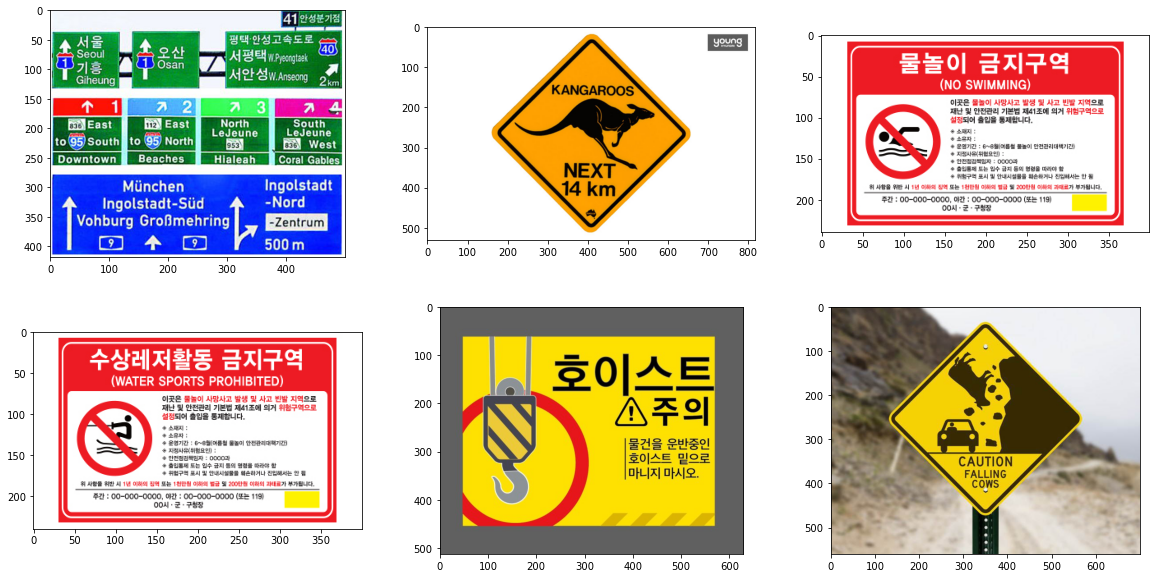

In [6]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    pil_img = Image.open(img_paths[np.random.randint(len(img_paths))])
    plt.imshow(pil_img)
plt.show()

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1) Google OCR API

In [35]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [39]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/Image/15.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)



-rw-rw-r-- 1 ssac17 ssac17 2352  3월 18 21:15 /home/ssac17/aiffel/ocr_python/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #591138836653 by visiting https://console.developers.google.com/billing/enable?project=591138836653 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

### 2)  keras-ocr

In [17]:
import matplotlib.pyplot as plt
import keras_ocr


Looking for /home/ssac17/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac17/.keras-ocr/crnn_kurapan.h5


/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


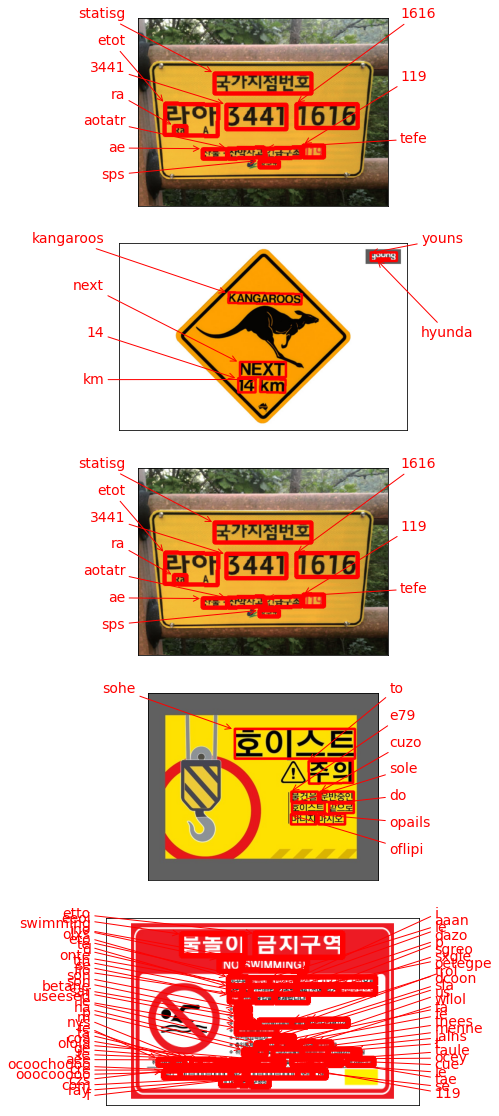

In [18]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

random_idx = np.random.choice(np.arange(len(img_paths)), 5)

image_paths = []
for i in random_idx :
    image_paths.append(img_paths[i])

images = [ keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3) Pytesseract

- 1) 테서랙트 설치하기

`$ sudo apt install tesseract-ocr`

`$ sudo apt install libtesseract-dev`

- 2) 테서랙트 파이썬 wrapper 설치하기

`$ pip install pytesseract`


#### 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [27]:

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


In [30]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/Image'
img_file_path = work_dir + '/8.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/ssac17/aiffel/ocr_python/Image/0000.png
/home/ssac17/aiffel/ocr_python/Image/0001.png
/home/ssac17/aiffel/ocr_python/Image/0002.png
/home/ssac17/aiffel/ocr_python/Image/0003.png
/home/ssac17/aiffel/ocr_python/Image/0004.png
/home/ssac17/aiffel/ocr_python/Image/0005.png
/home/ssac17/aiffel/ocr_python/Image/0006.png
/home/ssac17/aiffel/ocr_python/Image/0007.png
/home/ssac17/aiffel/ocr_python/Image/0008.png
/home/ssac17/aiffel/ocr_python/Image/0009.png
/home/ssac17/aiffel/ocr_python/Image/0010.png
/home/ssac17/aiffel/ocr_python/Image/0011.png
/home/ssac17/aiffel/ocr_python/Image/0012.png
/home/ssac17/aiffel/ocr_python/Image/0013.png
/home/ssac17/aiffel/ocr_python/Image/0014.png
/home/ssac17/aiffel/ocr_python/Image/0015.png
/home/ssac17/aiffel/ocr_python/Image/0016.png
/home/ssac17/aiffel/ocr_python/Image/0017.png
/home/ssac17/aiffel/ocr_python/Image/0018.png


#### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

In [32]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

=a

YOUNG

e: ,

=a


7

ue

1om

t=

7

a *

eee

me


Fe

a2 =

=O

ee

SB APEILICH

rT

om


Bee fe

od oe

me Sd

a2 2S

meio oP

.* e-S

S Al

+ TUAGE

a UP

mL) SSA of ee

"ATS

we Al

~ -

~

is


> P7uUC

=<»

OWL)

OFZ:

C—O) AOD

(= 119)

JOA, > =

ax!

Done


In [33]:
random_idx = np.random.choice(np.arange(len(cropped_image_path_list)), 5, replace=False)

# cropped_image_path_list 에서 랜덤하게 선택해서 copped_image_paths에 저장

cropped_image_pahts = []
for idx in random_idx:
    cropped_image_pahts.append(cropped_image_path_list[idx])
cropped_image_pahts

['/home/ssac17/aiffel/ocr_python/result_4/0039.png',
 '/home/ssac17/aiffel/ocr_python/result_4/0030.png',
 '/home/ssac17/aiffel/ocr_python/result_4/0007.png',
 '/home/ssac17/aiffel/ocr_python/result_4/0004.png',
 '/home/ssac17/aiffel/ocr_python/result_4/0028.png']

In [34]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_pahts)

JOA, > =

~

me

7

we Al

Done


### Step3. 테스트 결과 정리


원래는 자동차 번호판 인식을 하려고 했다가 조금더 글자수가 많은 도로 표지판으로 선택을 했다.

일부러 해외와 국내 표지판 두개를 사용해 보았다.

Google OCR API가 가장 정확했다. 이전에 노드에서도 그렇고 이번에는 결제를 하라는 안내 때문에 현재 주피터 노트북에는 나와있진 않지만 한국어, 영어, 숫자 제일 정확하게 인식한것 같다.

keras-ocr은 영어와 숫자는 잘 인식하는듯 보였으나 한국어는 제대로 인식하지 못했다.

테서렉트는 단어 자체를 잘못 쪼개어서 인식한것 같았다..
테서렉트에 대해서 좀더 자세히 찾아봐야겠다.

결론적으로 가장 좋은 선택지는 Google OCR API이다. 


### 느낀점

- 이전 cv관련 노드들에서 ocr 노드를 진행하면서 자동차 번호판 인식과 같은 부분을 해보고싶다고 했는데 나중에 기회가 되면 cctv(영상)을 가지고 인식을 해보는 것을 진행해보고 싶다고 생각했다.


### 참조

- [Tesseract OCR 판독(문자인식) 서버 만들기(무료)](https://blog.naver.com/goglkms/222247358992)